In [4]:
using PyPlot
using JuMP, Ipopt

In [5]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");

## Initialize model

In [6]:
dt = 1.
t = Array(2020:dt:2100);
model = ClimateModel(
    "soldatenko",
    t,
    dt,
    present_year,
    Economics0(t),
    Physics(),
    init_zero_controls(t)
);

In [7]:
maxslope = 1. /30.
optimize_controls!(
    model,
    maxslope = maxslope,
    obj_option = "temp",
    temp_goal = δT_init+1.0,
    temp_final = δT_init,
    max_deployment=Dict("remove"=>0., "mitigate"=>0., "geoeng"=>1., "adapt"=>0.)
);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      883
Number of nonzeros in inequality constraint Jacobian.:      283
Number of nonzeros in Lagrangian Hessian.............:      928

Total number of variables............................:      523
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      361
                     variables with only upper bounds:        0
Total number of equ

### Plotting the optimal solution state

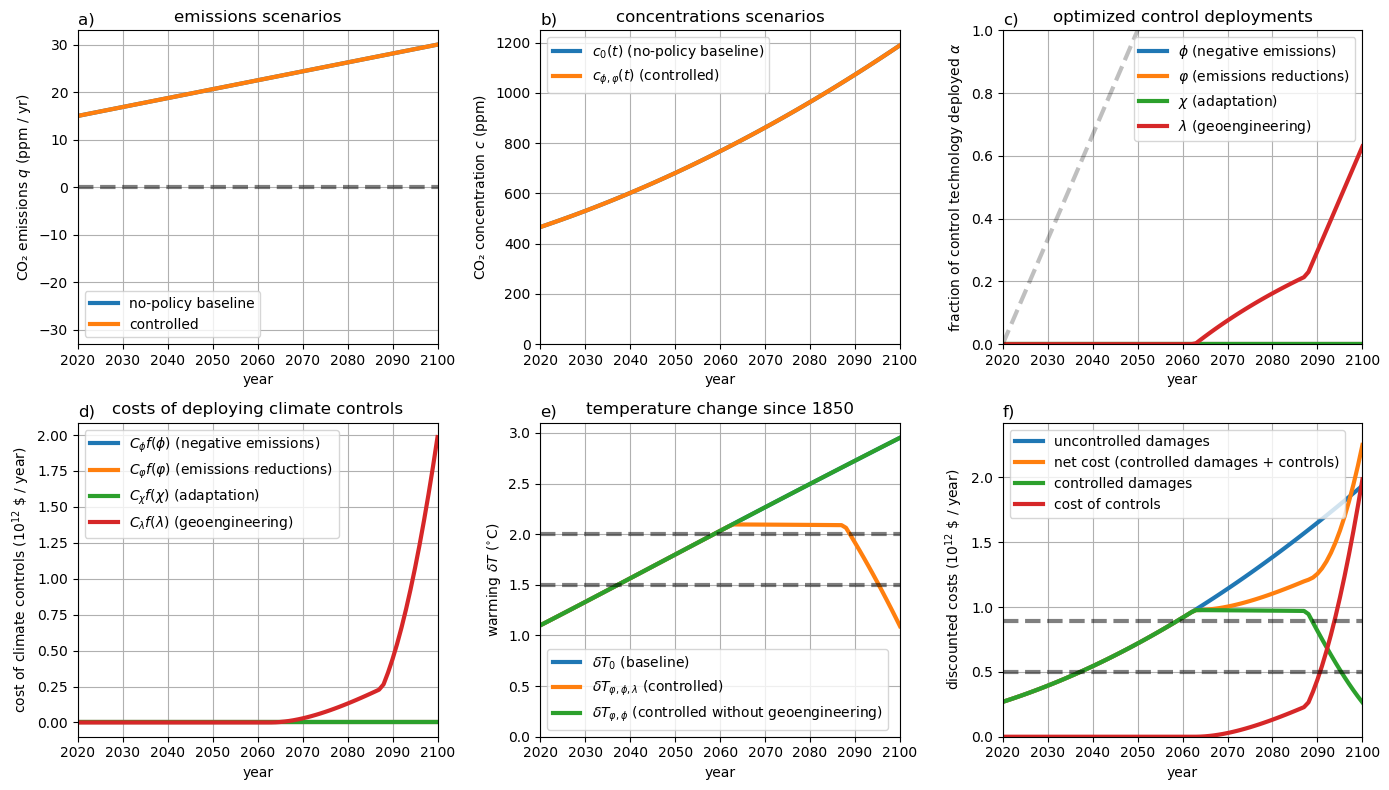

In [8]:
plot_state(model)

# Individual panels of the figure can be modified using PyPlot commands
# (see https://github.com/JuliaPy/PyPlot.jl)
subplot(2,3,3)
plot([2020., 2020. + 1. /maxslope], [0.,1.], "k--", alpha=0.25) # add a slope showing the faster possible ramp up of controls

savefig("../figures/replicate_soldatenko.png", bbox_inches="tight", dpi=100)